In [730]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score

from scipy.stats import loguniform, uniform

In [731]:
def printMetrics(y_train, y_pred_train, y_test, y_pred_test):
    
    print('Встроенные метрики')

    print('Обучающая выборка')
    print('MSE:', mean_squared_error(y_train, y_pred_train))
    print('RMSE:', root_mean_squared_error(y_train, y_pred_train))
    print('MAE:', mean_absolute_error(y_train, y_pred_train))
    print('MAPE:', mean_absolute_percentage_error(y_train, y_pred_train))
    print('R^2:', r2_score(y_train, y_pred_train))

    print()

    print('Тестовая выборка')
    print('MSE:', mean_squared_error(y_test, y_pred_test))
    print('RMSE:', root_mean_squared_error(y_test, y_pred_test))
    print('MAE:', mean_absolute_error(y_test, y_pred_test))
    print('MAPE:', mean_absolute_percentage_error(y_test, y_pred_test))
    print('R^2:', r2_score(y_test, y_pred_test))

    print()

    print('Ручные метрики')

    print('Тестовая выборка')
    print('MSE:', (1 / y_test.size) * np.sum((y_test - y_pred_test)**2))
    print('RMSE:', np.sqrt((1 / y_test.size) * np.sum((y_test - y_pred_test)**2)))
    print('MAE:', (1 / y_test.size) * np.sum(np.abs(y_test - y_pred_test)))
    print('MAPE:', (1 / y_test.size) * np.sum(np.abs(y_test - y_pred_test) / np.abs(y_test) * 100), '%')
    print('R^2:', 1 - ((1 / y_test.size) * np.sum((y_test - y_pred_test)**2)) / ((1 / y_test.size) * np.sum((y_test - y_test.mean())**2)))

    print('-' * 40)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.kdeplot(
        y_train, label='y_train (истинные)',
        fill=True, color='blue', alpha=0.4, linewidth=2, ax=axes[0]
    )
    sns.kdeplot(
        y_pred_train, label='y_pred_train (предсказанные)',
        fill=True, color='blue', alpha=0.7, linestyle='--', ax=axes[0]
    )
    axes[0].set_title('Распределения (Train)')
    axes[0].set_xlabel('Значение')
    axes[0].set_ylabel('Плотность')
    axes[0].legend()
    axes[0].grid(True)

    sns.kdeplot(
        y_test, label='y_test (истинные)',
        fill=True, color='green', alpha=0.4, linewidth=2, ax=axes[1]
    )
    sns.kdeplot(
        y_pred_test, label='y_pred_test (предсказанные)',
        fill=True, color='green', alpha=0.7, linestyle='--', ax=axes[1]
    )
    axes[1].set_title('Распределения (Test)')
    axes[1].set_xlabel('Значение')
    axes[1].set_ylabel('Плотность')
    axes[1].legend()
    axes[1].grid(True)

    plt.suptitle('Сравнение распределений: Истинные vs Предсказанные (Train и Test)', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [732]:
def gridSearchCV(model, X_train, X_test, y_train, y_test):

    if type(model) == ElasticNet:
        param_grid = {
            'alpha': np.arange(0.1, 1, 0.1),
            'max_iter': np.arange(1000, 10001, 1000),
            'l1_ratio': np.arange(0.1, 0.9, 0.1)
    }
    else:
        param_grid = {
            'alpha': np.arange(0.1, 1, 0.1),
            'max_iter': np.arange(1000, 10001, 1000),
        }

    grid_model = GridSearchCV(model, param_grid, cv=5, scoring='r2')

    grid_model.fit(X_train, y_train)

    print(grid_model.best_params_)
    print(grid_model.best_score_)

    y_pred_train = grid_model.predict(X_train)
    y_pred_test = grid_model.predict(X_test)

    print(grid_model.best_estimator_.coef_)

    printMetrics(y_train, y_pred_train, y_test, y_pred_test)

    print()

In [733]:
def randomizedSearchCV(model, X_train, X_test, y_train, y_test):

    if type(model) == ElasticNet:
        param_grid = {
            'alpha': loguniform(1e-4, 1e2),
            'max_iter': np.arange(1000, 10001, 100),
            'l1_ratio': uniform(0.1, 0.9)
        }
    else:
        param_grid = {
            'alpha': loguniform(1e-4, 1e2),
            'max_iter': np.arange(1000, 10001, 100),
        }

    randomized_model = RandomizedSearchCV(model, param_grid, n_iter=30, cv=5, scoring='r2', random_state=42)

    randomized_model.fit(X_train, y_train)

    print(randomized_model.best_params_)
    print(randomized_model.best_score_)

    y_pred_train = randomized_model.predict(X_train)
    y_pred_test = randomized_model.predict(X_test)

    print(randomized_model.best_estimator_.coef_)

    printMetrics(y_train, y_pred_train, y_test, y_pred_test)

    print()

In [734]:
def optunaSearch(model_class, X_train, X_test, y_train, y_test):

    def objective(trial):

        alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)
        max_iter = trial.suggest_int('max_iter', 1000, 10000)
        
        
        if model_class == ElasticNet:
            l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.99)
            model = model_class(
                alpha=alpha,
                max_iter=max_iter,
                l1_ratio=l1_ratio
            )
        else:
            model = model_class(
                alpha=alpha,
                max_iter=max_iter
            )
        
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        return mse  

    study = optuna.create_study(
        direction='minimize'
    )

    study.optimize(objective, n_trials=100)

    print(study.best_params)

    best_params = study.best_params
    best_model = model_class(alpha=best_params['alpha'], max_iter=best_params['max_iter']) if model_class != ElasticNet else \
                                 model_class(alpha=best_params['alpha'], max_iter=best_params['max_iter'], l1_ratio=best_params['l1_ratio'])
    best_model.fit(X_train, y_train)

    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    printMetrics(y_train, y_pred_train, y_test, y_pred_test)

    print()

In [735]:
def predictingWithoutRegularization(model, X_train, y_train, X_test, y_test):
    reg = model.fit(X_train, y_train)

    y_pred_test = reg.predict(X_test)
    y_pred_train = reg.predict(X_train)

    print(reg.coef_)

    printMetrics(y_train, y_pred_train, y_test, y_pred_test)

In [736]:
def predictingWithRegularization(model, X_train, y_train, X_test, y_test):

    # GridSearchCV
    print('GridSearchCV')
    gridSearchCV(model, X_train, X_test, y_train, y_test)

    # RandomizedSearchCV
    print('RandomizedSearchCV')
    randomizedSearchCV(model, X_train, X_test, y_train, y_test)

    #Optuna
    print('Optuna')
    model_class = model.__class__
    optunaSearch(model_class, X_train, X_test, y_train, y_test)

In [737]:
def gradient_descent(X_train, y_train, lambda_=0.9, learning_rate=0.01, iters=10000):
    w = np.zeros(X_train.shape[1])
    b = 0
    m = X_train.shape[0]

    for _ in range(iters):
        y_pred = X_train.dot(w) + b
        error = y_pred - y_train

        dw = (2/m) * X_train.T.dot(error) + 2 * lambda_ * w
        db = (2/m) * np.sum(error)

        w -= learning_rate * dw
        b -= learning_rate * db
        
    return w, b

## Загрузка и подготовка данных

In [738]:
df = pd.read_csv('/Users/macbook/Desktop/ВУЗ/Машинное обучение и большие данные/lab_1/mumbai_houses.csv')

In [739]:
X = df.drop('price', axis=1)
y = df['price']

In [740]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Решение задачи регрессии

### LinearRegression

[ 5.60309471e+06 -2.00195324e+03 -1.52906575e+05 -5.60694095e+04
  2.68916026e+05 -2.91353269e+18 -4.35047420e+03  1.45485388e+18
 -3.96182268e+04  1.45867881e+18  8.66629029e+06  1.59489161e+16
  1.59489161e+16 -3.82416038e+18 -3.82416038e+18]
Встроенные метрики
Обучающая выборка
MSE: 5321243735639.721
RMSE: 2306782.1170712505
MAE: 1486527.6665132744
MAPE: 0.1230431024321076
R^2: 0.9532239897756333

Тестовая выборка
MSE: 4723279708590.466
RMSE: 2173310.7712866254
MAE: 1424410.853284515
MAPE: 0.11269501117561256
R^2: 0.9585586568142516

Ручные метрики
Тестовая выборка
MSE: 4723279708590.466
RMSE: 2173310.7712866254
MAE: 1424410.853284515
MAPE: 11.269501117561257 %
R^2: 0.9585586568142516
----------------------------------------


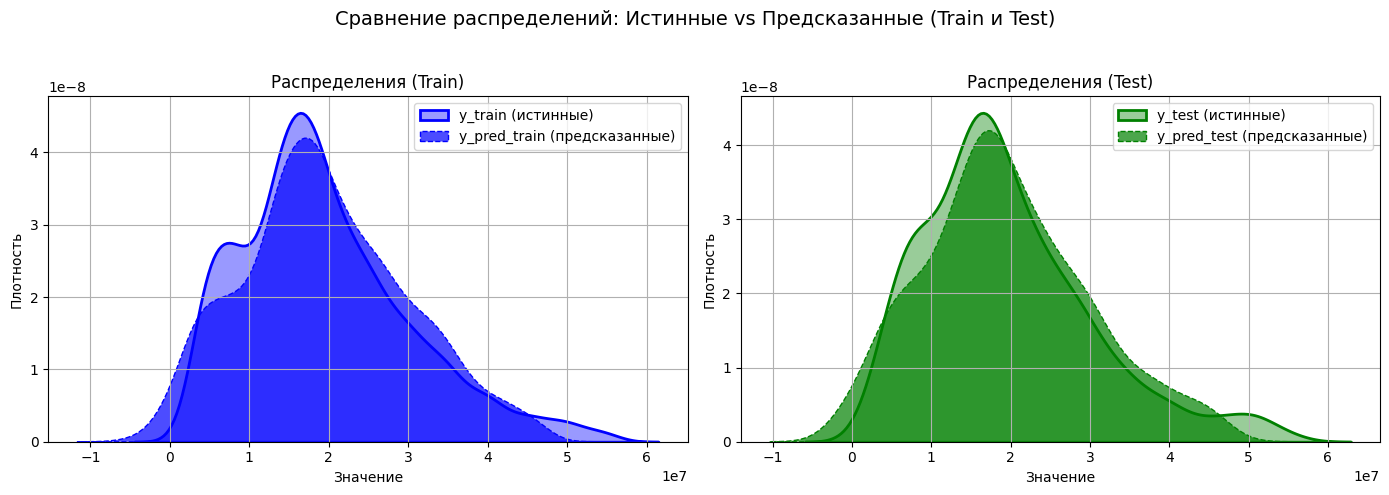

In [741]:
predictingWithoutRegularization(LinearRegression(), X_train, y_train, X_test, y_test)

### L1-regularization

GridSearchCV


/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.427e+14, tolerance: 3.947e+13

/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.496e+14, tolerance: 3.971e+13

/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e+14, tolerance: 3.915e+13

/Users/macbook/Libr

{'alpha': 0.9, 'max_iter': 4000}
0.9526510060349261
[ 5.60114047e+06 -2.23832250e+03 -1.54649747e+05 -5.50641922e+04
  2.68676769e+05  8.15998312e+03 -5.43176377e+03  4.88820479e+02
 -3.98020232e+04  5.18333243e-03  8.66691956e+06  4.69022260e+04
 -3.49331779e-11 -1.22595921e+04  1.70061520e-11]
Встроенные метрики
Обучающая выборка
MSE: 5320981027741.162
RMSE: 2306725.173864707
MAE: 1486336.669776039
MAPE: 0.12301565638776066
R^2: 0.9532262990905152

Тестовая выборка
MSE: 4726024859185.898
RMSE: 2173942.239155838
MAE: 1424905.7994415013
MAPE: 0.11269815192505167
R^2: 0.9585345712773068

Ручные метрики
Тестовая выборка
MSE: 4726024859185.898
RMSE: 2173942.239155838
MAE: 1424905.7994415013
MAPE: 11.269815192505167 %
R^2: 0.9585345712773068
----------------------------------------


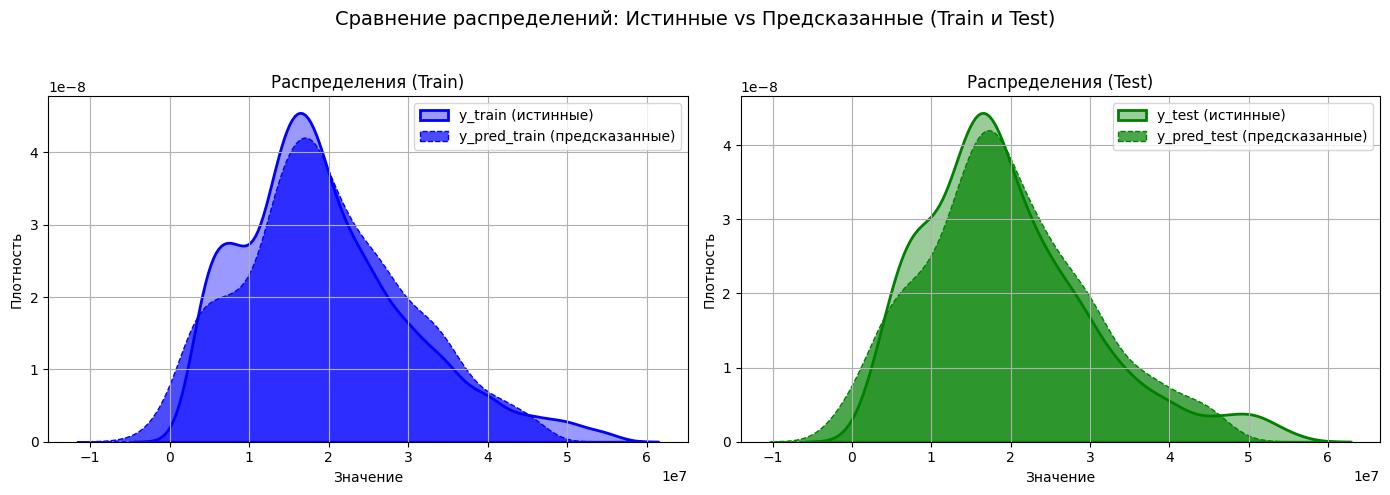


RandomizedSearchCV


/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.427e+14, tolerance: 3.947e+13

/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.496e+14, tolerance: 3.971e+13

/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e+14, tolerance: 3.915e+13

/Users/macbook/Libr

{'alpha': 89.79855655182439, 'max_iter': 4200}
0.9526516145087778
[ 5.60097313e+06 -2.19270506e+03 -1.54570171e+05 -5.46468889e+04
  2.68393902e+05  7.37794118e+03 -5.31609380e+03  1.18799111e+03
 -3.97128088e+04  5.15782068e-01  8.66683245e+06  4.68273527e+04
 -1.86635996e-10 -1.21628439e+04  1.57545529e-11]
Встроенные метрики
Обучающая выборка
MSE: 5320981167974.4795
RMSE: 2306725.204261331
MAE: 1486323.9636450147
MAPE: 0.12301124154313128
R^2: 0.9532262978578043

Тестовая выборка
MSE: 4726045895713.482
RMSE: 2173947.077486819
MAE: 1424891.2566647152
MAPE: 0.11269397958767231
R^2: 0.9585343867059892

Ручные метрики
Тестовая выборка
MSE: 4726045895713.482
RMSE: 2173947.077486819
MAE: 1424891.2566647152
MAPE: 11.26939795876723 %
R^2: 0.9585343867059892
----------------------------------------


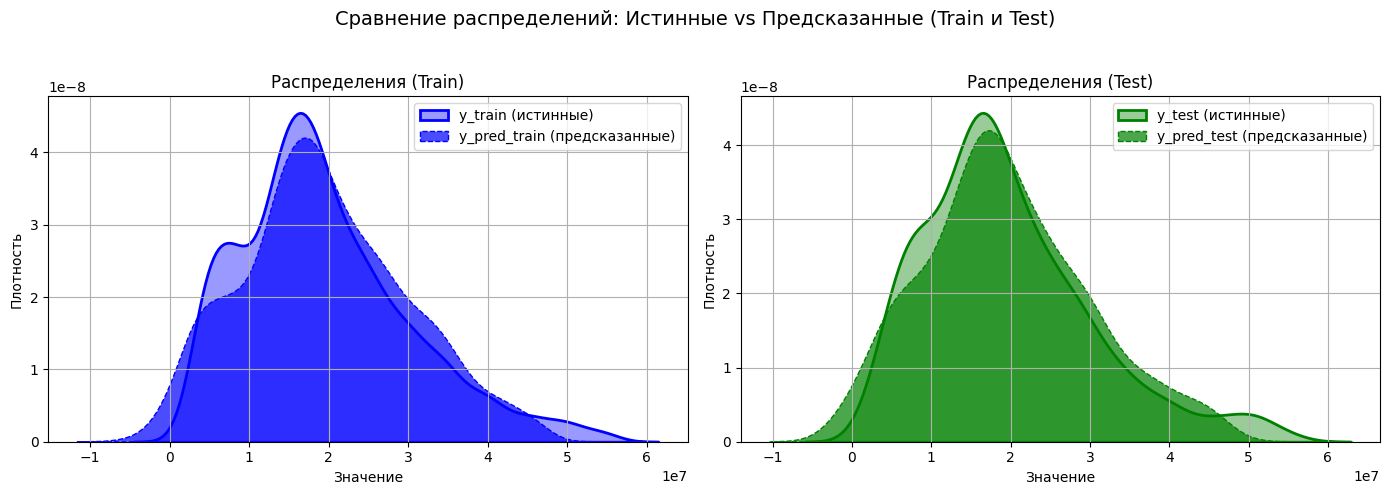

[I 2025-04-17 15:36:47,594] A new study created in memory with name: no-name-861b9426-5fac-4b72-a145-8aeb9162f289
/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.613e+14, tolerance: 4.955e+13

[I 2025-04-17 15:36:47,733] Trial 0 finished with value: 4726024654853.852 and parameters: {'alpha': 0.013397955790336851, 'max_iter': 2736}. Best is trial 0 with value: 4726024654853.852.
[I 2025-04-17 15:36:47,751] Trial 1 finished with value: 4726032376639.839 and parameters: {'alpha': 32.963560830053325, 'max_iter': 9743}. Best is trial 0 with value: 4726024654853.852.
[I 2025-04-17 15:36:47,768] Trial 2 finished with value: 4726038200434.239 and parameters: {'alpha': 57.859230262194885, 'max_iter': 5790}. Best is trial 0 with value: 4726024654853.8


Optuna


/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.613e+14, tolerance: 4.955e+13

[I 2025-04-17 15:36:48,134] Trial 3 finished with value: 4726024649013.572 and parameters: {'alpha': 0.0007286173265162925, 'max_iter': 7679}. Best is trial 3 with value: 4726024649013.572.
/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.613e+14, tolerance: 4.955e+13

[I 2025-04-17 15:36:48,520] Trial 4 finished with value: 4726024652223.669 and parameters: {'alpha': 0.007692235293517025, 'max_iter': 6145}. Best is trial 

{'alpha': 1.002089358952884e-05, 'max_iter': 7497}


/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.613e+14, tolerance: 4.955e+13



Встроенные метрики
Обучающая выборка
MSE: 5320981027727.096
RMSE: 2306725.1738616577
MAE: 1486336.798359033
MAPE: 0.12301570099540877
R^2: 0.9532262990906388

Тестовая выборка
MSE: 4726024648682.292
RMSE: 2173942.190740658
MAE: 1424905.9467456262
MAPE: 0.11269819407566047
R^2: 0.9585345731242336

Ручные метрики
Тестовая выборка
MSE: 4726024648682.292
RMSE: 2173942.190740658
MAE: 1424905.9467456262
MAPE: 11.269819407566048 %
R^2: 0.9585345731242336
----------------------------------------


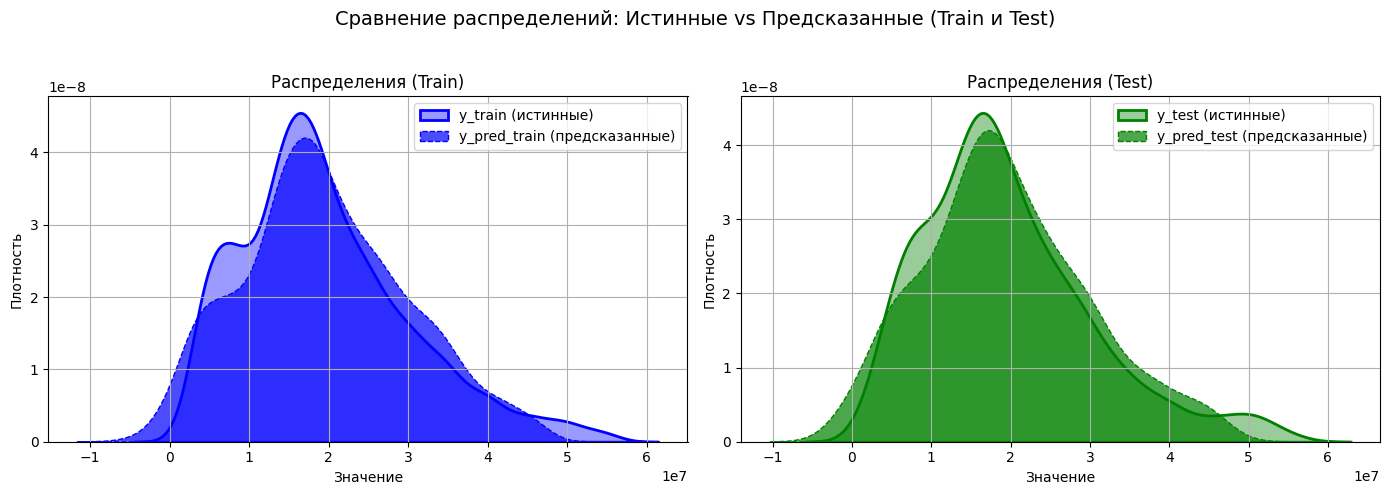

In [742]:
predictingWithRegularization(Lasso(), X_train, y_train, X_test, y_test)

### L2-regularization

[ 2249271.78098536 -1853371.38502567  -642089.54461663  1023325.7926443
  1033236.13931111     6884.39526008   124596.44753656     6884.39526008
    64368.96875404     6884.39526008  3718891.21696548   -18493.51643032
    18493.51643032    19659.78638147   -19659.78638147] 19498358.585858453
Встроенные метрики
Обучающая выборка
MSE: 23570788111731.848
RMSE: 4854975.603618606
MAE: 3559608.391276087
MAPE: 0.2585780017330864
R^2: 0.7928026828904122

Тестовая выборка
MSE: 23974802656468.027
RMSE: 4896407.117108219
MAE: 3523477.968964583
MAPE: 0.24351737976641863
R^2: 0.7896487004802473

Ручные метрики
Тестовая выборка
MSE: 23974802656468.027
RMSE: 4896407.117108219
MAE: 3523477.968964583
MAPE: 24.35173797664186 %
R^2: 0.7896487004802473
----------------------------------------


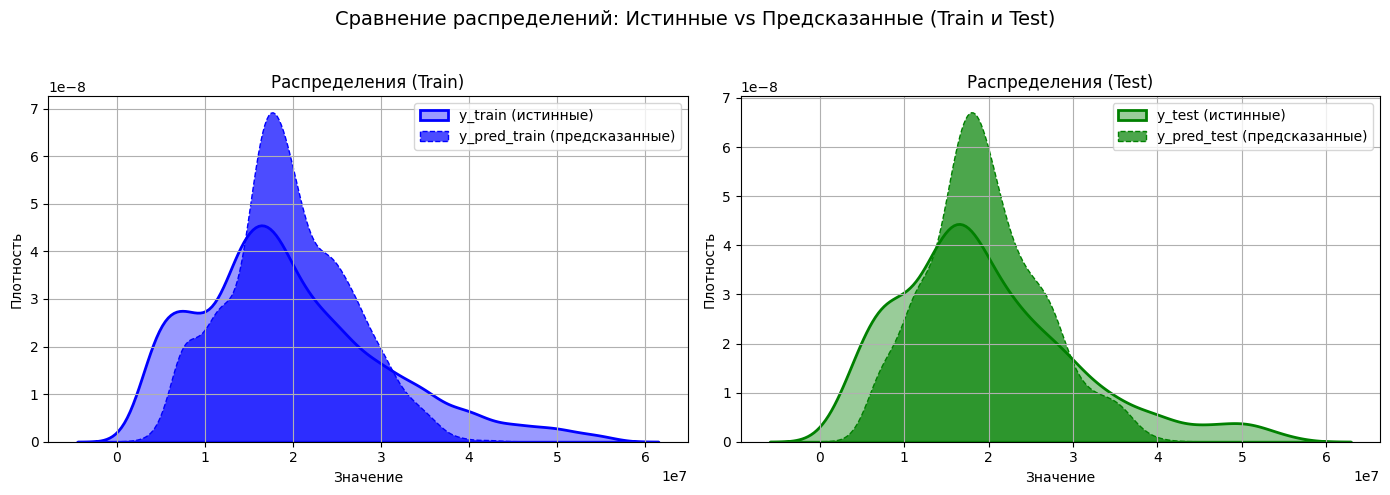

In [743]:
w, b = gradient_descent(X_train, y_train)

print(w, b)

y_pred_train = X_train.dot(w) + b
y_pred_test = X_test.dot(w) + b

printMetrics(y_train, y_pred_train, y_test, y_pred_test)

GridSearchCV
{'alpha': 0.9, 'max_iter': 1000}
0.95265116822505
[ 5.59813466e+06 -5.43406904e+03 -1.55750936e+05 -5.35349087e+04
  2.69553010e+05  2.95121960e+03 -5.27668522e+03  2.95121960e+03
 -3.97507458e+04  2.95121960e+03  8.66249495e+06  2.34280923e+04
 -2.34280923e+04 -6.08211940e+03  6.08211940e+03]
Встроенные метрики
Обучающая выборка
MSE: 5320992357068.915
RMSE: 2306727.629580249
MAE: 1486217.1373691012
MAPE: 0.12295257799319377
R^2: 0.9532261995008746

Тестовая выборка
MSE: 4726525957165.8125
RMSE: 2174057.4870885573
MAE: 1424859.774452508
MAPE: 0.11263166819226378
R^2: 0.9585301747192716

Ручные метрики
Тестовая выборка
MSE: 4726525957165.8125
RMSE: 2174057.4870885573
MAE: 1424859.774452508
MAPE: 11.26316681922638 %
R^2: 0.9585301747192716
----------------------------------------


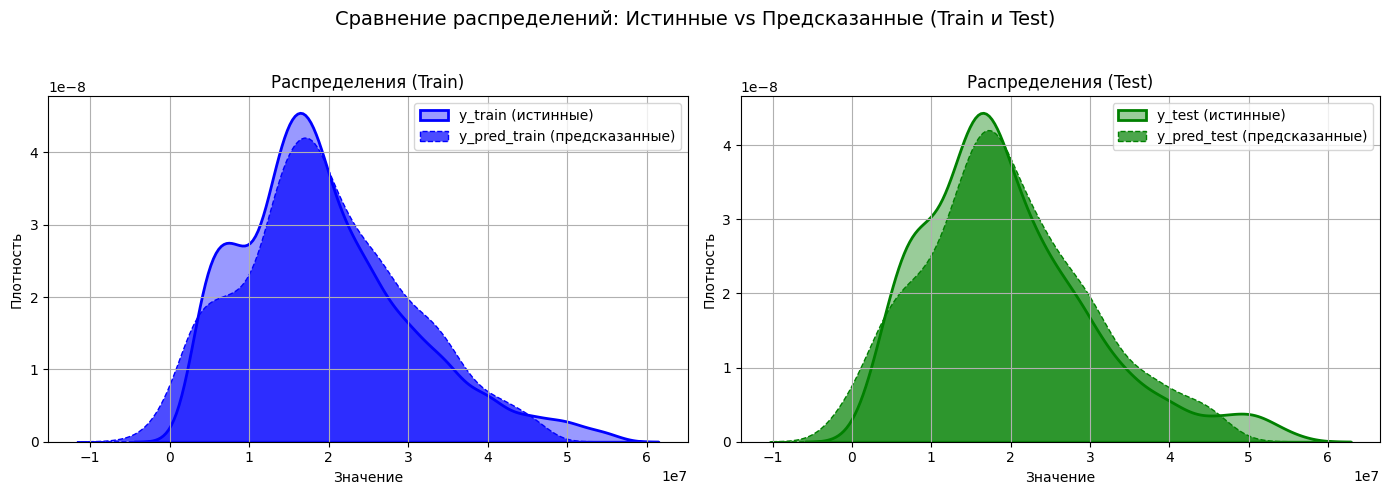


RandomizedSearchCV
{'alpha': 0.944351568796268, 'max_iter': 1100}
0.952651168522468
[ 5.59798657e+06 -5.59136291e+03 -1.55805099e+05 -5.34594153e+04
  2.69596019e+05  2.95456658e+03 -5.26899225e+03  2.95456658e+03
 -3.97481746e+04  2.95456658e+03  8.66227705e+06  2.34269397e+04
 -2.34269397e+04 -6.07974829e+03  6.07974829e+03]
Встроенные метрики
Обучающая выборка
MSE: 5320993500223.058
RMSE: 2306727.877367215
MAE: 1486211.3356330863
MAPE: 0.12294947251733104
R^2: 0.9532261894520604

Тестовая выборка
MSE: 4726551249023.966
RMSE: 2174063.3038216634
MAE: 1424857.8434488138
MAPE: 0.11262841489920328
R^2: 0.958529952812326

Ручные метрики
Тестовая выборка
MSE: 4726551249023.966
RMSE: 2174063.3038216634
MAE: 1424857.8434488138
MAPE: 11.262841489920326 %
R^2: 0.958529952812326
----------------------------------------


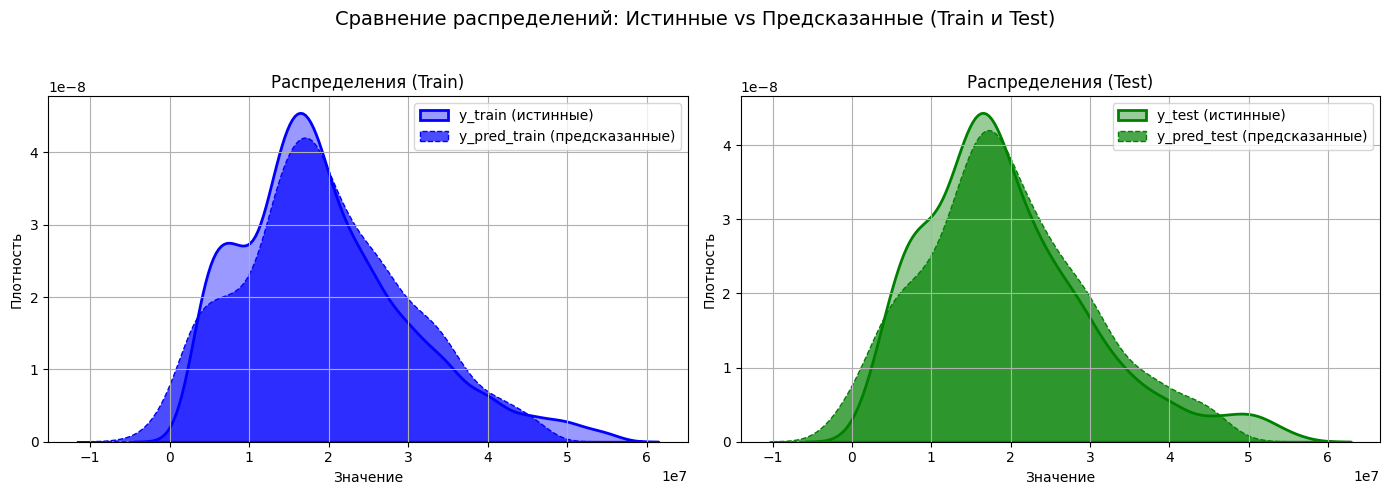

[I 2025-04-17 15:37:24,828] A new study created in memory with name: no-name-f441e5d4-aadb-4c0d-b8ef-110b5533c345
[I 2025-04-17 15:37:24,831] Trial 0 finished with value: 4728644075576.799 and parameters: {'alpha': 4.33067728710335, 'max_iter': 1885}. Best is trial 0 with value: 4728644075576.799.
[I 2025-04-17 15:37:24,835] Trial 1 finished with value: 4726024656255.897 and parameters: {'alpha': 1.3921267813466676e-05, 'max_iter': 9818}. Best is trial 1 with value: 4726024656255.897.
[I 2025-04-17 15:37:24,843] Trial 2 finished with value: 4726025195361.231 and parameters: {'alpha': 0.0010042395762231962, 'max_iter': 5559}. Best is trial 1 with value: 4726024656255.897.
[I 2025-04-17 15:37:24,848] Trial 3 finished with value: 4728315983027.977 and parameters: {'alpha': 3.832071182886403, 'max_iter': 5720}. Best is trial 1 with value: 4726024656255.897.
[I 2025-04-17 15:37:24,854] Trial 4 finished with value: 4726024723321.524 and parameters: {'alpha': 0.00013712132185076596, 'max_iter


Optuna


[I 2025-04-17 15:37:25,029] Trial 19 finished with value: 4726025849543.763 and parameters: {'alpha': 0.0022058827039774568, 'max_iter': 2939}. Best is trial 17 with value: 4726024654781.826.
[I 2025-04-17 15:37:25,044] Trial 20 finished with value: 4726024679345.719 and parameters: {'alpha': 5.6337537313220575e-05, 'max_iter': 4528}. Best is trial 17 with value: 4726024654781.826.
[I 2025-04-17 15:37:25,053] Trial 21 finished with value: 4726024656227.201 and parameters: {'alpha': 1.3868557597207263e-05, 'max_iter': 3051}. Best is trial 17 with value: 4726024654781.826.
[I 2025-04-17 15:37:25,070] Trial 22 finished with value: 4726024671350.672 and parameters: {'alpha': 4.1650547221565624e-05, 'max_iter': 6558}. Best is trial 17 with value: 4726024654781.826.
[I 2025-04-17 15:37:25,078] Trial 23 finished with value: 4726024813963.755 and parameters: {'alpha': 0.0003036305267552618, 'max_iter': 8937}. Best is trial 17 with value: 4726024654781.826.
[I 2025-04-17 15:37:25,099] Trial 24 

{'alpha': 1.001538869627376e-05, 'max_iter': 3364}
Встроенные метрики
Обучающая выборка
MSE: 5320981027727.099
RMSE: 2306725.1738616587
MAE: 1486336.7970155515
MAPE: 0.12301570029264511
R^2: 0.9532262990906388

Тестовая выборка
MSE: 4726024654129.688
RMSE: 2173942.1919935425
MAE: 1424905.9461813082
MAPE: 0.11269819333182117
R^2: 0.9585345730764391

Ручные метрики
Тестовая выборка
MSE: 4726024654129.688
RMSE: 2173942.1919935425
MAE: 1424905.9461813082
MAPE: 11.269819333182117 %
R^2: 0.9585345730764391
----------------------------------------


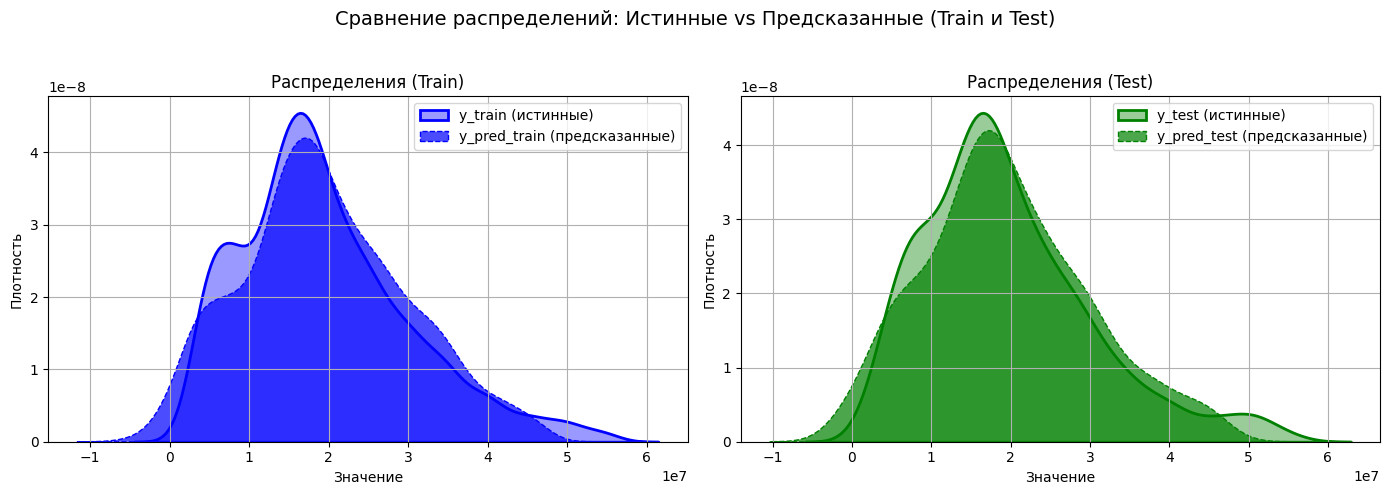

In [744]:
predictingWithRegularization(Ridge(), X_train, y_train, X_test, y_test)

### L1-regularization and L2-regularization

GridSearchCV
{'alpha': 0.1, 'l1_ratio': 0.8, 'max_iter': 1000}
0.9518584740101803
[ 5.32967637e+06 -2.83822778e+05 -2.50772650e+05  8.07200926e+04
  3.48076726e+05  8.76142951e+03  8.54594789e+03  8.76019800e+03
 -3.48049068e+04  8.76042316e+03  8.26882511e+06  2.12743432e+04
 -2.12743216e+04 -1.88197959e+03  1.88197128e+03]
Встроенные метрики
Обучающая выборка
MSE: 5412900876227.014
RMSE: 2326564.1784027824
MAE: 1494838.4386084073
MAPE: 0.1185761399526733
R^2: 0.9524182842755201

Тестовая выборка
MSE: 4865640219517.8545
RMSE: 2205819.6253360915
MAE: 1439251.902256399
MAPE: 0.10765678095925287
R^2: 0.9573096071806442

Ручные метрики
Тестовая выборка
MSE: 4865640219517.8545
RMSE: 2205819.6253360915
MAE: 1439251.902256399
MAPE: 10.765678095925287 %
R^2: 0.9573096071806442
----------------------------------------


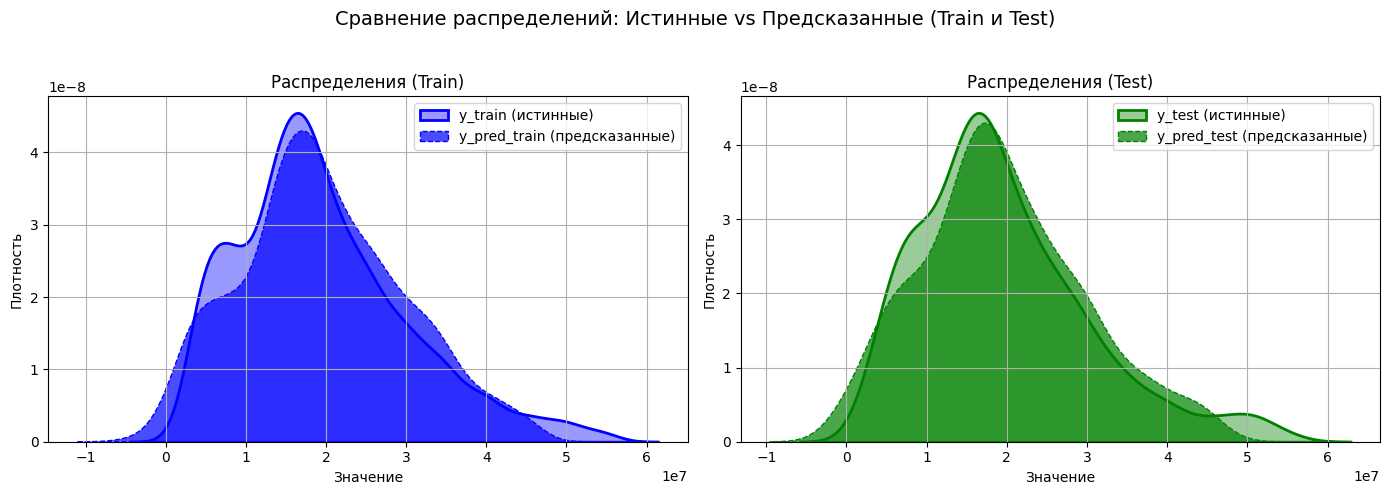


RandomizedSearchCV


/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.405e+15, tolerance: 3.947e+13

/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.225e+15, tolerance: 4.017e+13

/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.365e+15, tolerance: 3.971e+13

/Users/macbook/Libr

{'alpha': 0.0005397956855996448, 'l1_ratio': 0.5456592191001431, 'max_iter': 5600}
0.9526511667764923
[ 5.59757261e+06 -6.03094331e+03 -1.55956459e+05 -5.32483915e+04
  2.69716208e+05  3.11774901e+03 -5.24746516e+03  4.03641035e+03
 -3.97410347e+04  1.73791865e+03  8.66166815e+06  2.49268167e+04
 -2.19209910e+04 -6.46772758e+03  5.67861644e+03]
Встроенные метрики
Обучающая выборка
MSE: 5320996986231.712
RMSE: 2306728.632984754
MAE: 1486195.2066600781
MAPE: 0.12294079863386642
R^2: 0.9532261588085521

Тестовая выборка
MSE: 4726622284151.159
RMSE: 2174079.6407103306
MAE: 1424852.458582985
MAPE: 0.11261932390149237
R^2: 0.9585293295608427

Ручные метрики
Тестовая выборка
MSE: 4726622284151.159
RMSE: 2174079.6407103306
MAE: 1424852.458582985
MAPE: 11.261932390149237 %
R^2: 0.9585293295608427
----------------------------------------


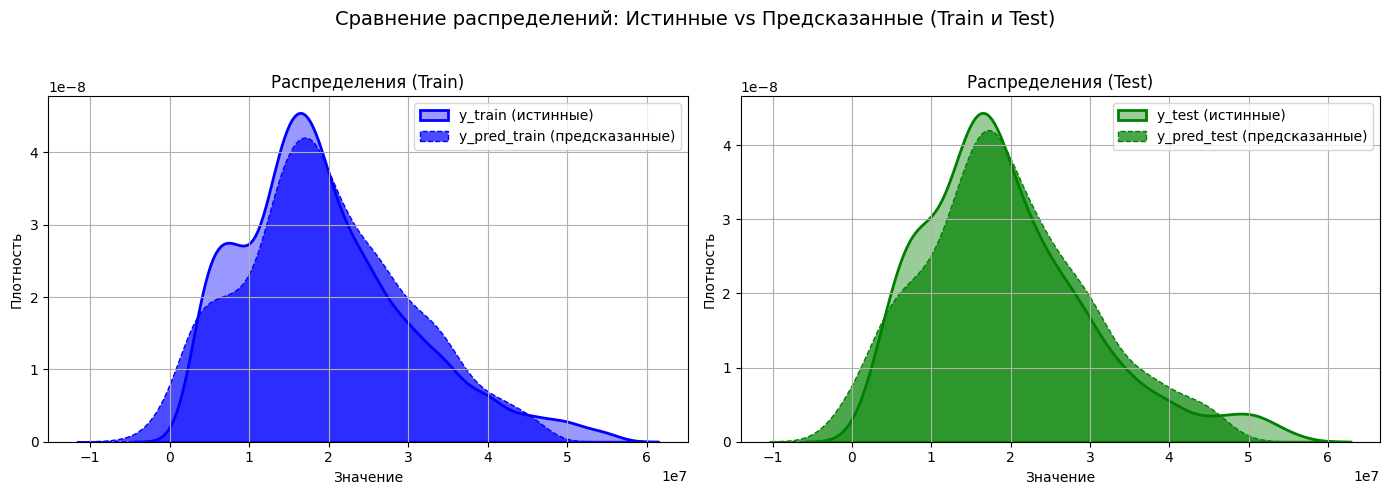

[I 2025-04-17 15:37:56,152] A new study created in memory with name: no-name-689c66aa-7775-410e-a8dc-bab567c05249
[I 2025-04-17 15:37:56,187] Trial 0 finished with value: 4779381879173.607 and parameters: {'alpha': 0.09217406393310502, 'max_iter': 1352, 'l1_ratio': 0.8842465866186364}. Best is trial 0 with value: 4779381879173.607.



Optuna


/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.160e+16, tolerance: 4.955e+13

[I 2025-04-17 15:37:56,431] Trial 1 finished with value: 4726183745011.405 and parameters: {'alpha': 0.0001090405194897848, 'max_iter': 3881, 'l1_ratio': 0.38967096371609444}. Best is trial 1 with value: 4726183745011.405.
[I 2025-04-17 15:37:56,436] Trial 2 finished with value: 10881024759442.715 and parameters: {'alpha': 5.506742479533899, 'max_iter': 9858, 'l1_ratio': 0.9489261035959413}. Best is trial 1 with value: 4726183745011.405.
[I 2025-04-17 15:37:56,445] Trial 3 finished with value: 8545993537122.915 and parameters: {'alpha': 0.23949860389331656, 'max_iter': 6078, 'l1_ratio': 0.21827851826339045}. Best is trial 1 with value: 4726183745011.405.
[I 2025-04

{'alpha': 1.6304634190869428e-05, 'max_iter': 8302, 'l1_ratio': 0.9762013870589905}


/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.157e+16, tolerance: 4.955e+13



Встроенные метрики
Обучающая выборка
MSE: 5320981027767.116
RMSE: 2306725.1738703325
MAE: 1486336.571587587
MAPE: 0.123015582316047
R^2: 0.953226299090287

Тестовая выборка
MSE: 4726025569760.582
RMSE: 2173942.4025858142
MAE: 1424905.8515673429
MAPE: 0.11269806849177338
R^2: 0.9585345650428319

Ручные метрики
Тестовая выборка
MSE: 4726025569760.582
RMSE: 2173942.4025858142
MAE: 1424905.8515673429
MAPE: 11.269806849177337 %
R^2: 0.9585345650428319
----------------------------------------


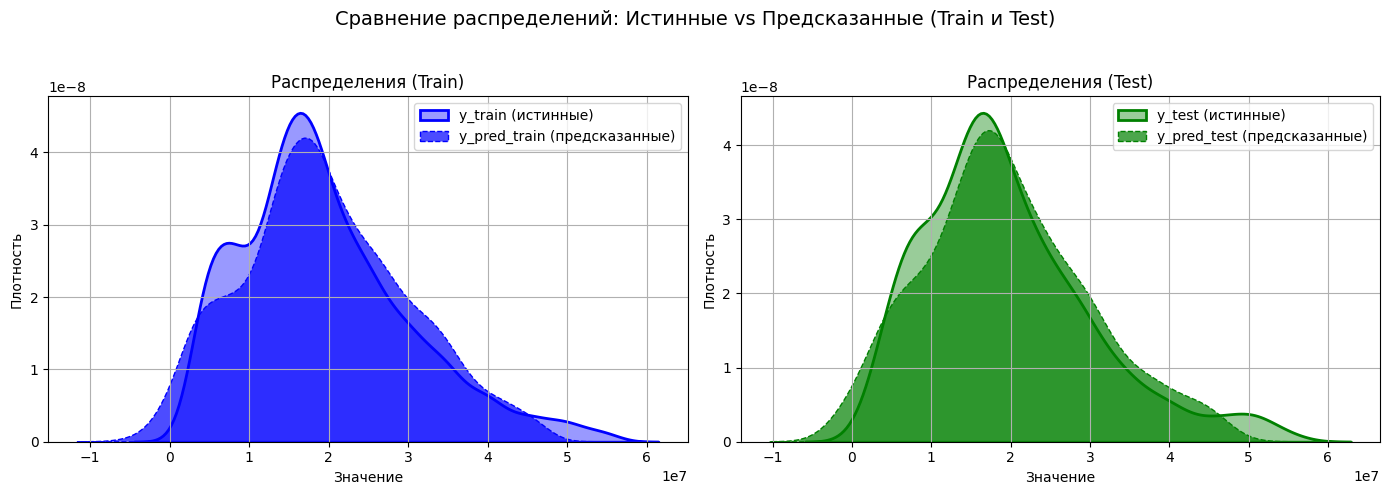

In [745]:
predictingWithRegularization(ElasticNet(), X_train, y_train, X_test, y_test)

### Polynomial regression

[ 5.49946860e+06 -8.47007823e+03  2.59997599e+03  3.32718208e+03
  1.47932272e+03 -6.84288474e+03  1.39662358e+06  1.52288210e+02
 -5.01228620e+03 -1.12124830e+04  9.13211889e+06 -1.60316586e+05
  1.09770406e+05  8.21658241e+05 -8.28717432e+05 -6.89760782e-09
  9.24046617e-10 -4.65661287e-10  3.31783667e-09 -1.28056854e-09
  1.07408242e+04  9.31322575e-10 -5.32333291e+03 -4.07453626e-09
 -5.41749134e+03  2.57695162e+06  1.06194127e+05 -1.00164513e+05
  1.92616540e+03  1.92616540e+03  2.79396772e-09 -2.32830644e-10
  0.00000000e+00  3.37604433e-09 -5.45223260e+03  4.42378223e-09
  3.53634467e+03  1.61526259e-09  1.91588794e+03  6.05359674e-09
  1.60186041e+05 -1.62456127e+05 -1.19314348e+03 -1.19314348e+03
  3.14321369e-09 -1.22236088e-09  9.31322575e-10  6.10981539e+02
  1.97906047e-09 -8.85424273e+02 -1.60071068e-10  2.74442735e+02
  3.02679837e-09 -5.17718668e+04  4.72664030e+04  4.23477903e+02
  4.23477903e+02 -4.65661287e-10 -3.72529030e-09  3.21960954e+03
 -1.45519152e-09 -1.05558

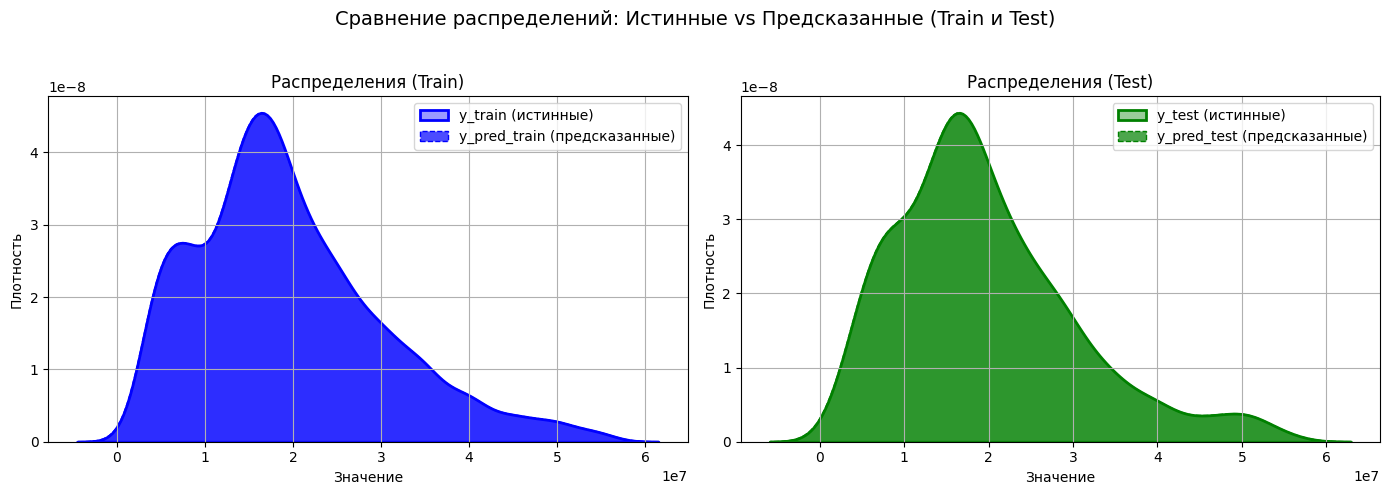

In [746]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

predictingWithoutRegularization(LinearRegression(), X_train_poly, y_train, X_test_poly, y_test)

Встроенные метрики
Обучающая выборка
MSE: 1.1562487309875605e-14
RMSE: 1.0752900683013679e-07
MAE: 8.448203247386014e-08
MAPE: 8.360558757459583e-15
R^2: 1.0

Тестовая выборка
MSE: 1.0077929397540745e-14
RMSE: 1.0038889080740332e-07
MAE: 8.128590272915703e-08
MAPE: 7.760371199652863e-15
R^2: 1.0

Ручные метрики
Тестовая выборка
MSE: 1.0077929397540745e-14
RMSE: 1.0038889080740332e-07
MAE: 8.128590272915703e-08
MAPE: 7.760371199652863e-13 %
R^2: 1.0
----------------------------------------


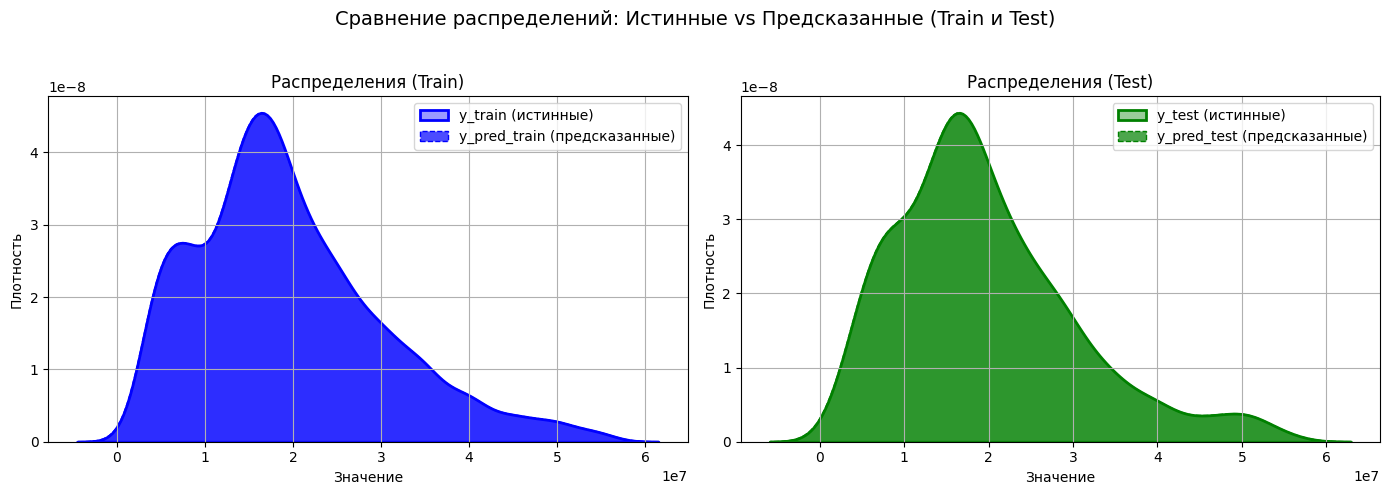

In [747]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),   
    ('linreg', LinearRegression())   
])         

pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

printMetrics(y_train, y_pred_train, y_test, y_pred_test)

# Вывод

### В ходе данной лабораторной работы я могу сделать вывод, что лучшая модель это линейная регрессия с полиномиальными признаками степенью 2. Почему это модель опережает другие, потому что скорее всего наши данные имеют полиномиальную зависимость, поэтому обычая линйеная регрессия не справляется. Если посмотреть модель на втором месте, то у нас будет ElasticNet с GridSearchCV - наш MAPE = 10 % что говорит о небольшом отклонении данных